In [1]:
from skimage import measure
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import sklearn
import sklearn.cluster
import itertools
import statistics
import cv2
import scipy

Populating the interactive namespace from numpy and matplotlib


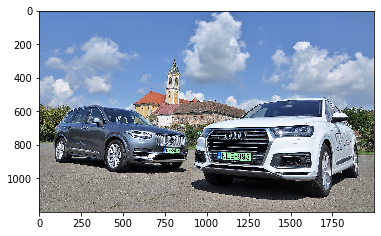

In [2]:
img = mpimg.imread("DSC_2144.jpg")
imgplot = plt.imshow(img)
plt.show()

## Segmentation

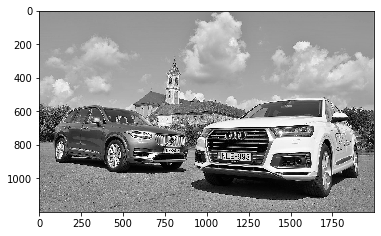

In [3]:
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gimg,cmap='gray')
plt.show()

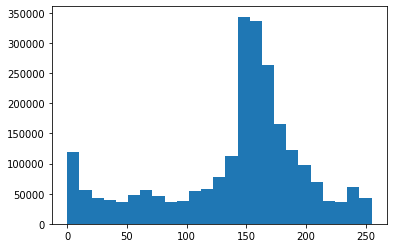

In [4]:
plt.hist(gimg.flatten(),bins=25);

### Mean

In [5]:
print(gimg.mean())

140.67476875


### Otsu
<pre>threshold(src, thresh, maxval, type[, dst])</pre> 

In [7]:
thr,res = cv2.threshold(gimg,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print(thr)

107.0


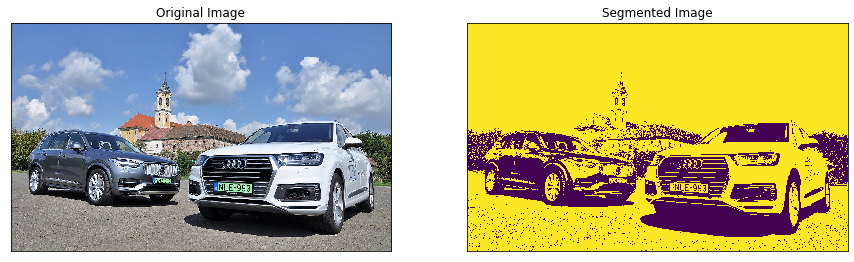

In [8]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res)
plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
plt.show()

### TASK: segment the image according to mean

### k-means clustering in RGB space

In [9]:
r = img[::20,::20,0].flatten()
g = img[::20,::20,1].flatten()
b = img[::20,::20,2].flatten()
np.shape(r)

(6000,)

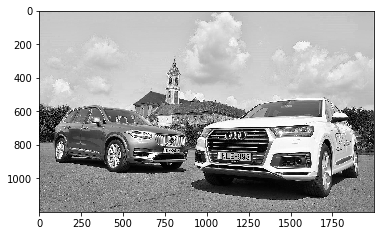

In [14]:
plt.imshow(img[:,:,2],cmap='gray')
plt.show()

### RGB space

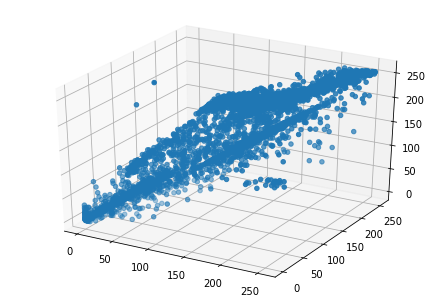

In [15]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(r, g, b)
plt.show()

### K-means clustering
Segment the image into two parts using k-means clustering

First we need to flatten the 2d image

In [16]:
print(img.shape)
print(img.reshape((-1,3)).shape)

(1200, 2000, 3)
(2400000, 3)


### Warning
You can stop the next command if it takes too long! And this is just a 2.4 megapixel image!

In [17]:
rgb = img.reshape((-1,3))
kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(rgb)

In [18]:
kmeans.cluster_centers_

array([[145.10623793, 162.37477105, 188.83820344],
       [ 39.88225431,  44.44374853,  50.07613826]])

In [19]:
D = 10
sm_img = img[::D,::D,:]
rgb = sm_img.reshape((-1,3))
np.shape(rgb)
kmeans = sklearn.cluster.KMeans(n_clusters=2).fit(rgb)

In [20]:
kmeans.cluster_centers_

array([[145.00472991, 162.43886052, 189.28013975],
       [ 39.54272475,  44.08266914,  49.72511585]])

Now the real clustering but using the centers from the decimated. It is faster in two steps.

In [21]:
rgb = img.reshape((-1,3))
kmeans = sklearn.cluster.KMeans(n_clusters=2,init=kmeans.cluster_centers_).fit(rgb)

/usr/lib/python3/dist-packages/sklearn/cluster/k_means_.py:896: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


In [22]:
kmeans.cluster_centers_

array([[145.09333731, 162.35973617, 188.82031207],
       [ 39.83474601,  44.3924861 ,  50.01651171]])

Cluster the ponts of the images

In [23]:
pred = kmeans.predict(rgb)
res = pred.reshape((1200,2000))
np.shape(res)

(1200, 2000)

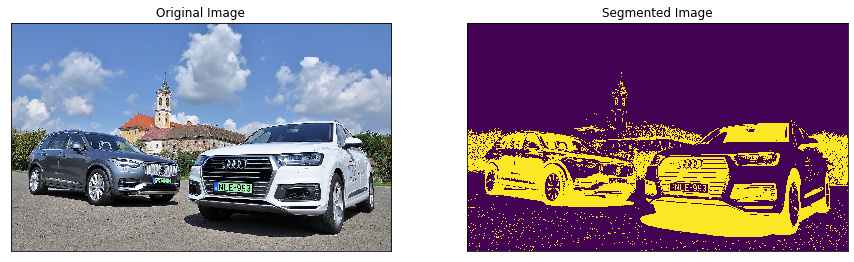

In [24]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res)
plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])
plt.show()

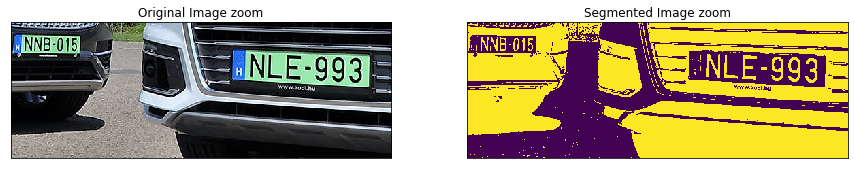

In [25]:
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img[800:1000,740:1300])
plt.title('Original Image zoom'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow(res[800:1000,740:1300])
plt.title('Segmented Image zoom'), plt.xticks([]), plt.yticks([])
plt.show()

### Find connected components

In [26]:
regions = measure.label(res,connectivity=1,background=-10)
patches = measure.regionprops(regions)

### Boundary box
x_min, y_min, x_max, y_max

In [27]:
print(patches[5].area, patches[5].bbox)

24 (285, 806, 290, 814)


### TASK: select regions which fulfill the following conditions
 * area > 100
 * area < 0.3 * area of the whole image
 * aspect ratio is between 2 and 5 and lying flat
 
 1. Draw rectangles around the objects
 2. Plot the corresponding part from the original image
   * matplotlib.patches.Rectangle( (x0, y0), w, h )
   * see example below
 

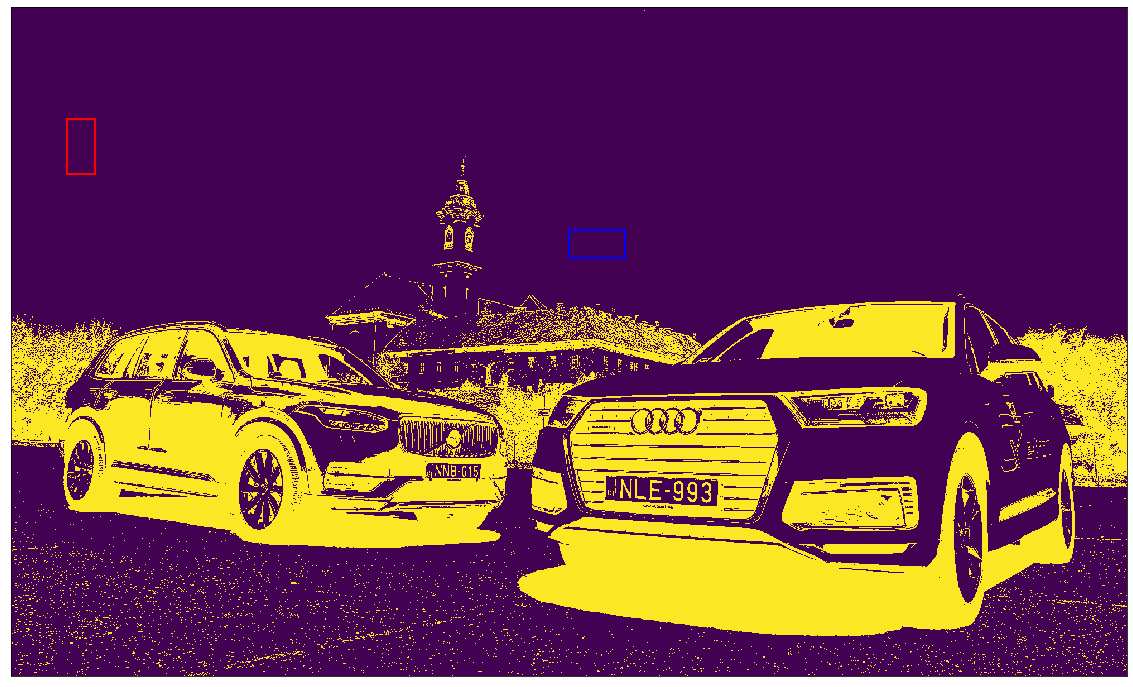

In [28]:
#plot rectangle example, important! Rectangle requires width and height
#Here it is unimportant but origin is at top left corner!

fig, (ax1) = plt.subplots(1,figsize=(20,20))
plt.xticks([]),plt.yticks([])
ax1.imshow(res);
rectBorder = matplotlib.patches.Rectangle(\
            (100, 200), 50, 100, edgecolor="red", linewidth=2, fill=False)
ax1.add_patch(rectBorder)
rectBorder = matplotlib.patches.Rectangle(\
            (1000, 400), 100, 50, edgecolor="blue", linewidth=2, fill=False)
ax1.add_patch(rectBorder)
plt.show()

## Pattern matching

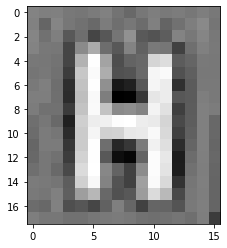

In [31]:
fig, ax = plt.subplots()
ax.imshow(gimg[863:881,1067:1083],cmap='gray');

### Create pattern

In [32]:
template = gimg[863:881,1067:1083]
w, h = template.shape[::-1]

### Find pattern

In [33]:
res = cv2.matchTemplate(gimg,template,cv2.TM_CCOEFF_NORMED)

In [34]:
np.shape(res)

(1183, 1985)

### Fantastic beasts and where to find them

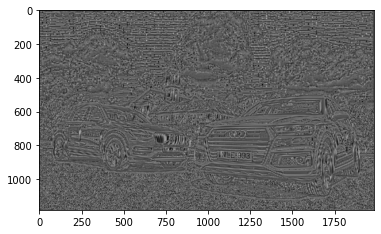

In [35]:
gimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(res,cmap='gray')
plt.show()

In [39]:
threshold = 0.48
loc = np.where( res >= threshold)
print(loc)

(array([160, 861, 862, 863, 864, 865]), array([ 788, 1067, 1067, 1067, 1067, 1067]))


### TASK
 1. plot the corresponding parts of the image
 2. decrease the threshold to 0.6, 0.5, 0.45 (do not go much below!)

### TASK
 1. write a code which resizes the pattern (factors: 0.5-2) and searches for its matches, can you find the other H?
<pre>cv2.resize(template,new_x,new_y)</pre> does the trick
 2. plot the found plate number with the numbers included (just estimate the size)

## Homework
Try to find the letters on the number plates. Please note, that any other route is possible, I even encourage you to try to find better methods if you have the ambition.
By the end of the class after thresholding and looking for horizontal patches you should end up with about two dozen of them matching the criteria. Go through them and perform the following:
* Use k-means clustering with k=2 on these rectangles. If the original patch was a number plate we expect this to find letters and other dirt. Let us call smallpatches these patches found on the patches.
* Discard smallpatches which:
   - are larger than 1/5th of the patch
   - are smaller than 1/100th of the patch
   - are shorter than the half of the patch (in the vertical direction)
   - have an aspect ratio < 0.1
   - have an aspect ratio > 1.2
   - have less than 4 or more than 10 smallpatches matching the above criteria.
   
* Finally keep only those patches the relative height of which differs less than 5% from the median

Check the images rendszam*.png in the zip file. These are the images I recieved with and without the last rule
   